Rosemonde Lareau-Dussault
===
PhD Mathematics, University of Toronto
---
----------

1- Introduction
===

-------
This notebook studies the behavior of cyclists in Montréal in 2015. To goal is to relate weather data and whether it's a working day or not with how many cyclists used bike lanes.

I am using the data set [Montreal bike lanes](https://www.kaggle.com/pablomonleon/montreal-bike-lanes). From the data set description: the "rows correspond to days of the year (in) 2015 and the columns are the bike lanes in Montreal. The numbers in the cells are the number of bikes that used that lane."

To get weather data, I downloaded a [2015 weather report](http://climat.meteo.gc.ca) and I [uploaded it to kaggle](https://www.kaggle.com/rosemondeld/weather-montreal-2015-en).

Given that I want to predict the quantity of cyclists in a day, I want to predict a Poisson process. That is if $y_i$ is the quantity of cyclist on day $i$ and the weather conditions are $X_i$, I assume that $P(y_i|X_i)$ follows a Poisson distribution. Because the quantity of cyclists is large enough, this Poisson distribution should be approximatable by a normal distribution (at least during the summer time ;) ).

This notebook is organized as follows: In Section **2 - Data**, I download, clear and visualize the data. I also try to make the number of cyclists depend on my factors linearly by using transformations and I scale the factors to have them on a comparable scale. In section **3- Modeling**, I create a predictive model that outputs an expected number of cyclists using bike lanes in Montréal given certain weather conditions and knowing whether it is a working day or a weekend or a holiday. Such a model could be used by the city to provide adapted support for cyclists (ex: more police force or less construction when a large number of cyclists is expected) or by an advertising company that wants to target advertising to cyclists.

In [35]:
#I import all the libraries I'll need
from matplotlib import pyplot
import seaborn as sns # for pictures

#from mlxtend.preprocessing import minmax_scaling # to scale variable between 0 and 1

import numpy as np # linear algebra
import pandas as pd # for data structure

from sklearn.model_selection import cross_val_score # as I have very few data points, I will use cross validation instead of creating a training and a testing set
from sklearn.metrics import mean_absolute_error # this is a metric I'll use to compare models
from sklearn.model_selection import train_test_split # to separate our data into a traning and a testing set
from sklearn.preprocessing import MinMaxScaler
#mport xgboost as xgb
#rom xgboost import XGBRegressor # This is the model I'll use for decision tree (it is a combinaison of decision trees)

2- Data
===
----------
2.1-Montreal bike data
---
I load the bike data, and set the index to be the date.

In [3]:
bike = pd.read_csv('./comptagesvelo2015.csv',parse_dates=['Date'], dayfirst=True)
bike=bike.set_index('Date')

Let's have a quick look at the data.

In [4]:
bike.head()

,Unnamed: 1,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_1,Maisonneuve_2,Maisonneuve_3,Notre-Dame,Parc,...,Pont_Jacques_Cartier,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Laurent U-Zelt Test,Saint-Urbain,Totem_Laurier,University,Viger
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,00:00,58,12,4,17,33.0,49,21,16,16,...,NaN,58,91,24,3,NaN,17,78,21,6
2015-01-02,00:00,75,7,5,15,30.0,113,27,9,32,...,NaN,109,177,32,13,NaN,11,57,77,4
2015-01-03,00:00,79,7,3,7,30.0,107,36,12,18,...,NaN,71,131,33,5,NaN,14,174,40,5
2015-01-04,00:00,10,1,21,0,10.0,35,29,1,0,...,NaN,6,11,6,1,NaN,1,20,6,0
2015-01-05,00:00,42,0,2,0,27.0,90,21,1,1,...,NaN,0,5,49,20,NaN,0,41,56,10


First, we're going to remove the 'Unnamed: 1' column as it contains no information.

In [5]:
bike['Unnamed: 1'].describe()

count       319
unique        1
top       00:00
freq        319
Name: Unnamed: 1, dtype: object

In [6]:
bike = bike.drop('Unnamed: 1', 1)

C:\Users\jorge.ruiz\AppData\Local\Temp\ipykernel_1996\2454334016.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  bike = bike.drop('Unnamed: 1', 1)


Now, I find and observe the columns that have missing values.

In [8]:
print(bike.isnull().sum())

Berri1                           0
Boyer                            0
Brébeuf                          0
CSC (Côte Sainte-Catherine)      0
Maisonneuve_1                  257
Maisonneuve_2                    0
Maisonneuve_3                    0
Notre-Dame                       0
Parc                             0
Parc U-Zelt Test               267
PierDup                          0
Pont_Jacques_Cartier           110
Rachel / Hôtel de Ville          0
Rachel / Papineau                0
René-Lévesque                    0
Saint-Antoine                    0
Saint-Laurent U-Zelt Test      269
Saint-Urbain                     0
Totem_Laurier                    0
University                       0
Viger                            0
dtype: int64


<AxesSubplot:xlabel='Date'>

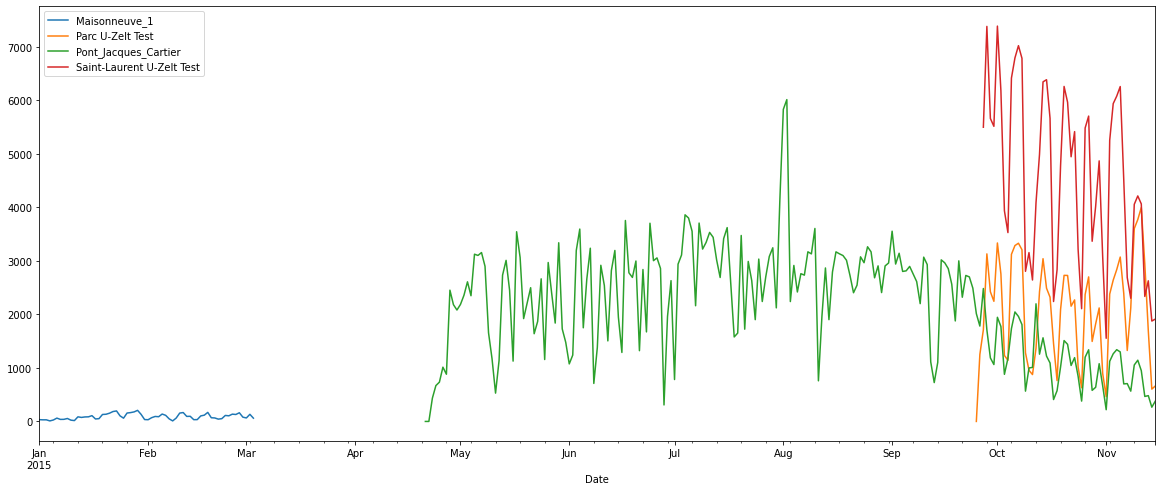

In [9]:
bike[['Maisonneuve_1','Parc U-Zelt Test','Pont_Jacques_Cartier','Saint-Laurent U-Zelt Test']].plot(figsize=(20,8))

As we can see, four columns have missing values. From the name of columns 'Parc U-Zelt Test' and 'Saint-Laurent U-Zelt Test' I deduce that these are probably new bike lanes being tested for the end of 2015. For the two others, there is also missing information for a large portion of the year (probably because they didn't collect the data for a time or because the bike lane was temporary closed). I remove these from the data set.

In [10]:
bike = bike.drop(['Maisonneuve_1', 'Parc U-Zelt Test', 'Pont_Jacques_Cartier', 'Saint-Laurent U-Zelt Test'], 1)

C:\Users\jorge.ruiz\AppData\Local\Temp\ipykernel_1996\622107247.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  bike = bike.drop(['Maisonneuve_1', 'Parc U-Zelt Test', 'Pont_Jacques_Cartier', 'Saint-Laurent U-Zelt Test'], 1)


We can see from plotting all the remaining bike lanes togetther that there seems to be a general trend, i.e. some days where there were more people on all the bike lanes and some where there were less. Therefore, I added all the colomns and keep only a total count of cyclist on all bike lanes.

<AxesSubplot:xlabel='Date'>

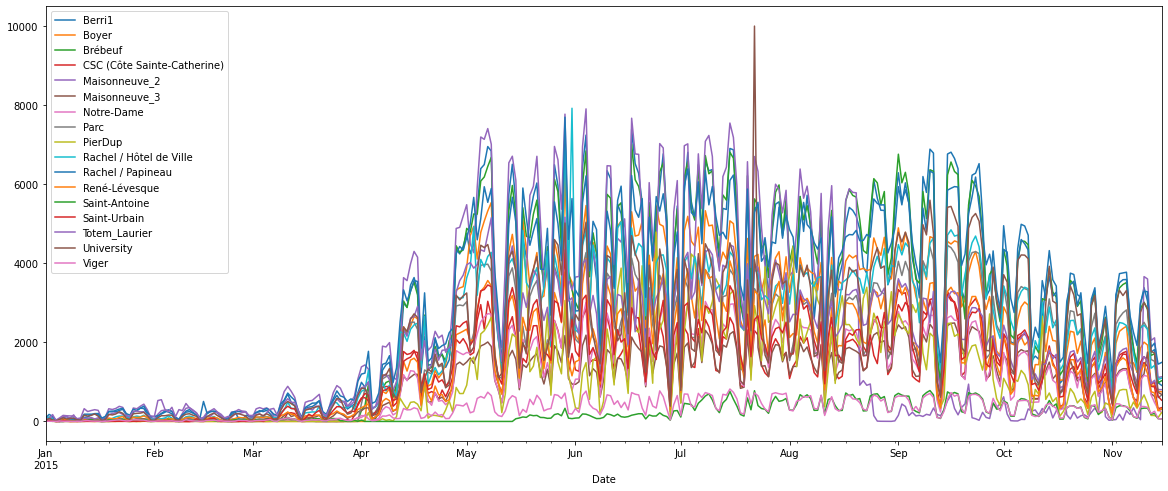

In [11]:
bike.plot(figsize=(20,8))

In [12]:
#I create the total column.
bike['total']=bike['Berri1']+bike['Boyer']+bike['Brébeuf']+bike['CSC (Côte Sainte-Catherine)']+bike['Maisonneuve_2']+bike['Maisonneuve_3']+bike['Notre-Dame']+bike['Parc']+bike['PierDup']+bike['Rachel / Hôtel de Ville']+bike['Rachel / Papineau']+bike['René-Lévesque']+bike['Saint-Antoine']+bike['Saint-Urbain']+bike['Totem_Laurier']+bike['University']+bike['Viger']
#I droped all the other columns.
bike = bike.drop(['Berri1', 'Boyer', 'Brébeuf', 'CSC (Côte Sainte-Catherine)','Maisonneuve_2','Maisonneuve_3','Notre-Dame','Parc','PierDup','Rachel / Hôtel de Ville','Rachel / Papineau','René-Lévesque','Saint-Antoine','Saint-Urbain','Totem_Laurier','University','Viger'], 1)

C:\Users\jorge.ruiz\AppData\Local\Temp\ipykernel_1996\57918607.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  bike = bike.drop(['Berri1', 'Boyer', 'Brébeuf', 'CSC (Côte Sainte-Catherine)','Maisonneuve_2','Maisonneuve_3','Notre-Dame','Parc','PierDup','Rachel / Hôtel de Ville','Rachel / Papineau','René-Lévesque','Saint-Antoine','Saint-Urbain','Totem_Laurier','University','Viger'], 1)


Let's look at the final bike data:

In [13]:
bike.describe()

,total
count,319.000000
mean,28837.815047
std,22431.867228
min,148.000000
25%,3163.500000
50%,29859.000000
75%,49242.000000
max,78279.000000


<AxesSubplot:xlabel='Date'>

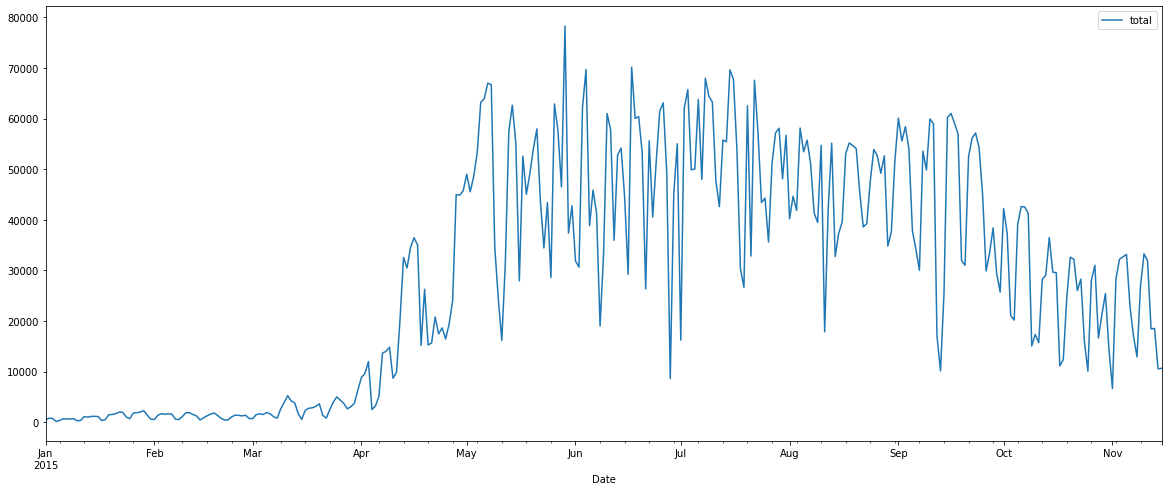

In [14]:
bike.plot(figsize=(20,8))

<AxesSubplot:>

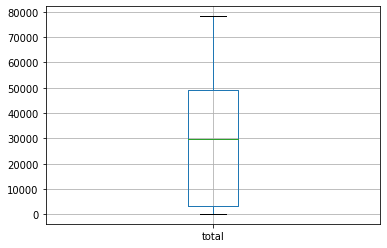

In [15]:
bike.boxplot()

----------
2.2-Montreal weather data
---
I load the weather data.

In [16]:
weather = pd.read_csv('./eng-daily-01012015-12312015.csv')
weather = weather[:319] #I only keep until November 15th as I have no data after this date (I think Montréal closes its bike lanes after this date).

Let's have a quick look at the data.

In [17]:
weather.sample(5)

,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
235,2015-08-24,2015,8,24,‡,28.5,NaN,18.7,NaN,23.6,...,0.0,NaN,0.0,T,NaN,NaN,25.0,NaN,37,NaN
274,2015-10-02,2015,10,2,‡,13.0,NaN,4.0,NaN,8.5,...,0.0,NaN,0.0,NaN,NaN,NaN,4.0,NaN,54,NaN
8,2015-01-09,2015,1,9,‡,-6.1,NaN,-14.6,NaN,-10.4,...,2.6,NaN,2.6,NaN,12.0,NaN,22.0,NaN,57,NaN
50,2015-02-20,2015,2,20,‡,-14.6,NaN,-19.6,NaN,-17.1,...,1.6,NaN,1.6,NaN,16.0,NaN,23.0,NaN,59,NaN
30,2015-01-31,2015,1,31,‡,-14.7,NaN,-22.8,NaN,-18.8,...,0.0,T,0.0,T,14.0,NaN,26.0,NaN,41,NaN


I add a column to detect whether it is the weekend or not.

In [18]:
weather['index'] = weather.index
weather['weekend']=np.where((weather['index']%7==2) | (weather['index']%7==3), 1, 0)
weather = weather.drop(['index'],1)

C:\Users\jorge.ruiz\AppData\Local\Temp\ipykernel_1996\1171170330.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  weather = weather.drop(['index'],1)


I am going to make the data be the index as I did for the bike data. Note that I first create a column for the month. I will use this later to impute some missing values, as the weather is correlated with the month.

In [19]:
weather['Date']=pd.to_datetime(weather['Date/Time'], format = "%Y-%m-%d")
weather['month']=weather['Date'].dt.month
weather=weather.set_index('Date')
weather = weather.drop(['Date/Time'],1)

C:\Users\jorge.ruiz\AppData\Local\Temp\ipykernel_1996\1864899551.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  weather = weather.drop(['Date/Time'],1)


I manually add the Statutory Holidays in Québec in 2015 to the weekend column.

In [20]:
weather.at['2015-01-01', 'weekend']=1
weather.at['2015-04-03', 'weekend']=1
weather.at['2015-04-06', 'weekend']=1
weather.at['2015-05-18', 'weekend']=1
weather.at['2015-06-24', 'weekend']=1
weather.at['2015-07-01', 'weekend']=1
weather.at['2015-09-07', 'weekend']=1
weather.at['2015-10-12', 'weekend']=1

Now, I will remove columns that I don't intend to use. I only keep information about temperature and precipitation.
I also rename the columns to have more usable names, i.e. no degree sign, no space and no parenthesis.

In [21]:
weather = weather.drop(['Year','Month','Day','Data Quality','Max Temp Flag','Min Temp Flag','Mean Temp Flag','Heat Deg Days (°C)','Heat Deg Days Flag',
                       'Cool Deg Days (°C)','Cool Deg Days Flag','Total Rain Flag','Total Snow Flag','Total Precip (mm)','Total Precip Flag','Snow on Grnd Flag',
                       'Dir of Max Gust (10s deg)','Dir of Max Gust Flag','Spd of Max Gust (km/h)','Spd of Max Gust Flag'], 1)
weather.columns = ['max_temp','min_temp','mean_temp','rain','snow','snow_on_grnd','weekend','month']

C:\Users\jorge.ruiz\AppData\Local\Temp\ipykernel_1996\1622310369.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  weather = weather.drop(['Year','Month','Day','Data Quality','Max Temp Flag','Min Temp Flag','Mean Temp Flag','Heat Deg Days (°C)','Heat Deg Days Flag',


In [22]:
weather.head()

,max_temp,min_temp,mean_temp,rain,snow,snow_on_grnd,weekend,month
Date,,,,,,,,
2015-01-01,-3.0,-7.6,-5.3,0.0,1.8,0.0,1,1
2015-01-02,-3.4,-14.2,-8.8,0.0,0.0,1.0,0,1
2015-01-03,-8.5,-17.7,-13.1,0.0,17.0,1.0,1,1
2015-01-04,3.0,-8.6,-2.8,26.8,0.4,8.0,1,1
2015-01-05,-5.3,-17.9,-11.6,0.0,0.0,6.0,0,1


I now look if there are any missing values and I consider how I am going to deal with them.

In [23]:
print(weather.isnull().sum())

max_temp          0
min_temp          0
mean_temp         0
rain             11
snow              3
snow_on_grnd    220
weekend           0
month             0
dtype: int64


I start with the rain column. Let's look at the missing values.

In [24]:
rain = weather.drop(['snow','snow_on_grnd'],1)
norain = weather[rain.isnull().any(axis=1)]
norain

C:\Users\jorge.ruiz\AppData\Local\Temp\ipykernel_1996\2218504767.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  rain = weather.drop(['snow','snow_on_grnd'],1)


,max_temp,min_temp,mean_temp,rain,snow,snow_on_grnd,weekend,month
Date,,,,,,,,
2015-01-27,-9.6,-16.2,-12.9,NaN,NaN,10.0,0,1
2015-02-04,-3.7,-9.5,-6.6,NaN,7.0,13.0,0,2
2015-02-22,-3.6,-11.6,-7.6,NaN,1.2,19.0,1,2
2015-03-22,-8.9,-15.4,-12.2,NaN,NaN,5.0,1,3
2015-05-12,23.3,8.4,15.9,NaN,0.0,NaN,0,5
2015-06-30,25.3,13.7,19.5,NaN,0.0,NaN,0,6
2015-08-08,23.6,12.7,18.2,NaN,NaN,NaN,1,8
2015-08-13,23.1,16.3,19.7,NaN,0.0,NaN,0,8
2015-10-08,12.1,3.9,8.0,NaN,0.0,NaN,0,10


As some of the missing values for rain are when the temperature is bellow zero all day I can't impute from the average. Indeed, the quantity of rain depends on the temperature. Therefore, I impute this value by replacing the average total rain per month. During the cold months, there is no rain, so the missing values are replaced by 0.

In [25]:
weather['rain'].fillna(weather.groupby("month")["rain"].transform("mean"), inplace=True)

Now for snow.

In [26]:
snow = weather.drop(['rain','snow_on_grnd'],1)
nosnow = weather[snow.isnull().any(axis=1)]
nosnow

C:\Users\jorge.ruiz\AppData\Local\Temp\ipykernel_1996\3338981865.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  snow = weather.drop(['rain','snow_on_grnd'],1)


,max_temp,min_temp,mean_temp,rain,snow,snow_on_grnd,weekend,month
Date,,,,,,,,
2015-01-27,-9.6,-16.2,-12.9,0.893333,NaN,10.0,0,1
2015-03-22,-8.9,-15.4,-12.2,0.146667,NaN,5.0,1,3
2015-08-08,23.6,12.7,18.2,3.875862,NaN,NaN,1,8


Similarly, the snow probably depends on the current month (i.e. no snow when it's warm).

In [27]:
weather['snow'].fillna(weather.groupby("month")["snow"].transform("mean"), inplace=True)

Now for the quantity of snow on the ground.

In [28]:
snowongrnd = weather.drop(['rain','snow'],1)
nosnowongrnd = weather[snowongrnd.isnull().any(axis=1)]
nosnowongrnd

C:\Users\jorge.ruiz\AppData\Local\Temp\ipykernel_1996\3219280971.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  snowongrnd = weather.drop(['rain','snow'],1)


,max_temp,min_temp,mean_temp,rain,snow,snow_on_grnd,weekend,month
Date,,,,,,,,
2015-03-23,-6.1,-15.9,-11.0,0.000000,0.0,NaN,0,3
2015-03-31,2.2,-4.9,-1.4,0.000000,0.0,NaN,0,3
2015-04-10,11.5,3.1,7.3,12.000000,0.0,NaN,0,4
2015-04-11,8.4,2.6,5.5,0.000000,0.0,NaN,1,4
2015-04-12,16.8,2.3,9.6,0.000000,0.0,NaN,1,4
...,...,...,...,...,...,...,...,...
2015-11-10,12.8,-0.1,6.4,0.000000,0.0,NaN,0,11
2015-11-11,10.8,4.0,7.4,0.200000,0.0,NaN,0,11
2015-11-12,11.9,6.3,9.1,15.600000,0.0,NaN,0,11


There seems to be full months of missing data, so I can't impute from the monthly average. Most of those are during warmer months and therefore can safely be set to zero. The only two values to consider are 2015-03-23 and 2015-03-31. For those two values, I will take the average of the preceding and the following day, because the quantity of snow on the ground doesn't vary a lot from one day to the next.

In [29]:
weather.at['2015-03-23', 'snow_on_grnd']=weather.loc['2015-03-22']['snow_on_grnd']/2+weather.loc['2015-03-24']['snow_on_grnd']/2
weather.at['2015-03-31', 'snow_on_grnd']=weather.loc['2015-03-30']['snow_on_grnd']/2+weather.loc['2015-04-01']['snow_on_grnd']/2
weather['snow_on_grnd'].fillna(0, inplace=True)

I remove the month column.

In [30]:
weather = weather.drop(['month'],1)

C:\Users\jorge.ruiz\AppData\Local\Temp\ipykernel_1996\2546604382.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  weather = weather.drop(['month'],1)


I am now done clearing the weather values. Let's look at them!

In [31]:
weather.describe()

,max_temp,min_temp,mean_temp,rain,snow,snow_on_grnd,weekend
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,12.989342,2.887147,7.948589,2.493965,0.444222,3.134796,0.313480
std,13.537389,13.369551,13.367874,6.395783,1.552139,5.984572,0.464636
min,-18.000000,-27.500000,-20.900000,0.000000,0.000000,0.000000,0.000000
25%,2.200000,-6.550000,-2.300000,0.000000,0.000000,0.000000,0.000000
50%,16.800000,5.800000,11.100000,0.000000,0.000000,0.000000,0.000000
75%,24.500000,14.200000,19.300000,1.400000,0.000000,2.500000,1.000000
max,32.200000,21.900000,27.100000,47.200000,17.000000,23.000000,1.000000


<AxesSubplot:xlabel='Date'>

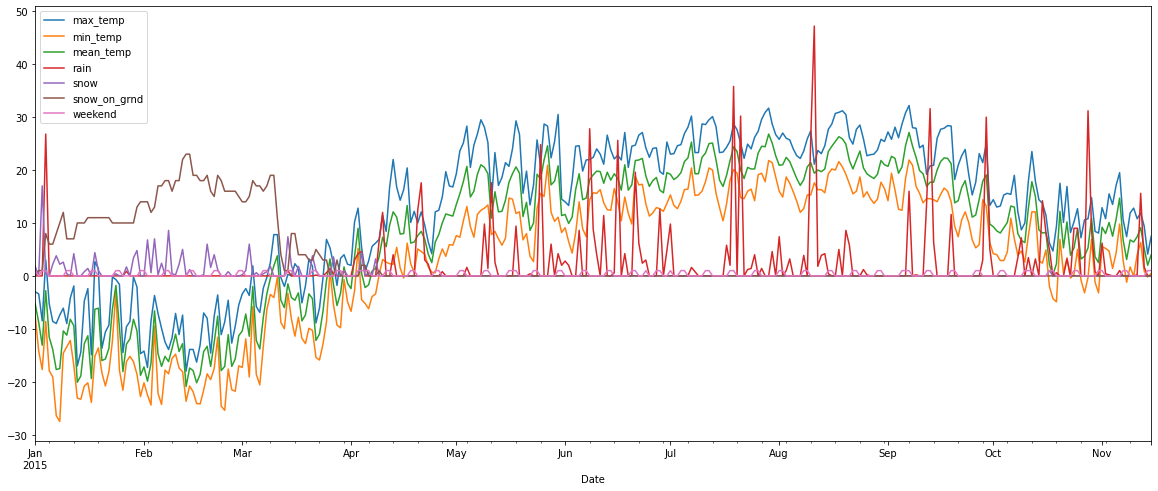

In [32]:
weather.plot(figsize=(20,8))

---------
2.3-Bike and Weather data --- Let's look at the data!
---
Now, I combine both data sets.


In [52]:
bike_and_weather = pd.concat([bike, weather], axis = 1)
bike_and_weather.head()


,total,max_temp,min_temp,mean_temp,rain,snow,snow_on_grnd,weekend
Date,,,,,,,,
2015-01-01,498,-3.0,-7.6,-5.3,0.0,1.8,0.0,1
2015-01-02,774,-3.4,-14.2,-8.8,0.0,0.0,1.0,0
2015-01-03,744,-8.5,-17.7,-13.1,0.0,17.0,1.0,1
2015-01-04,148,3.0,-8.6,-2.8,26.8,0.4,8.0,1
2015-01-05,344,-5.3,-17.9,-11.6,0.0,0.0,6.0,0


In order to plot the total number of cyclists with the weather data, I normalize all variables, i.e. I center and scale them so their range is between 0 and 1. This allows the data to all be on the same scale of magnitude.

I plot the weekend data separately, because otherwise it "clogs" the image.

In [47]:
#bike_and_weather = bike_and_weather.drop(bike_and_weather.columns[[0]], axis = 1)

In [48]:
bike_and_weather.head()

,max_temp,min_temp,mean_temp,rain,snow,snow_on_grnd,weekend
Date,,,,,,,
2015-01-01,-3.0,-7.6,-5.3,0.0,1.8,0.0,1
2015-01-02,-3.4,-14.2,-8.8,0.0,0.0,1.0,0
2015-01-03,-8.5,-17.7,-13.1,0.0,17.0,1.0,1
2015-01-04,3.0,-8.6,-2.8,26.8,0.4,8.0,1
2015-01-05,-5.3,-17.9,-11.6,0.0,0.0,6.0,0


In [50]:

minmax_scaler = MinMaxScaler()

scale_data = minmax_scaler.fit_transform(bike_and_weather )
#scale_data[['mean_temp','rain','snow','snow_on_grnd','total']].plot(figsize=(20,8))
#scale_data[['weekend','total']].plot(figsize=(20,8))

I observe that there are fewer bikers when it is cold and there is snow on the ground. I also observe that there are fewer bikers every time it rains. There also seems to be fewer bikers on the weekend.


I now plot a corellation matrix.

In [51]:
sns.heatmap(bike_and_weather[['mean_temp','rain','snow','snow_on_grnd','weekend','total']].corr(),annot=True, cmap="YlGnBu")

KeyError: "['total'] not in index"

We can see that the number of cyclists is highly correlated with the temperature. Let's compare the correlation with our 3 measures of the temperature. We can also see that this is why we introduce the log of the total number of cyclists. Indeed, by observing the pair plot between the temperature and the total number of cyclists, we see that the relationship is not linear, but could be with this transformation.

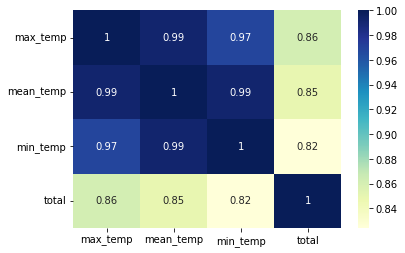

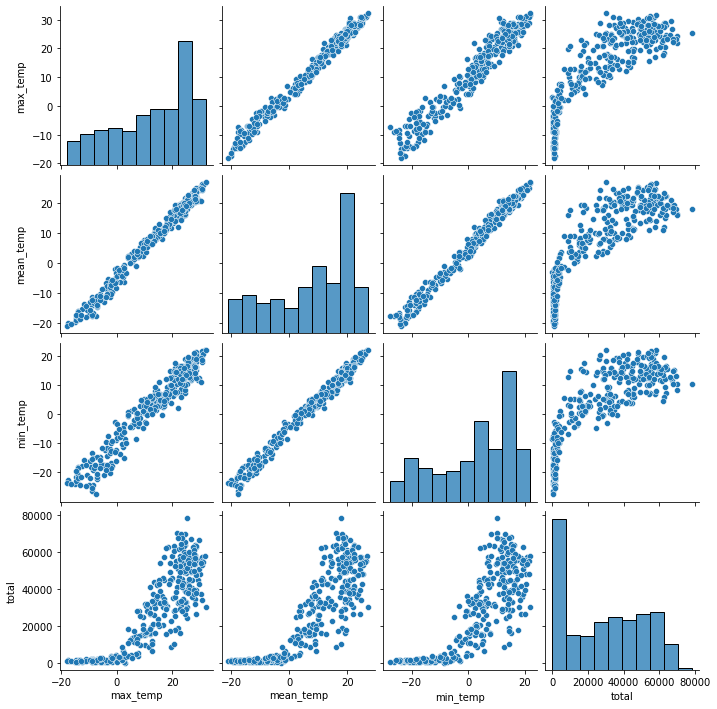

In [53]:
sns.heatmap(bike_and_weather[['max_temp','mean_temp','min_temp','total']].corr(),annot=True, cmap="YlGnBu")
sns.pairplot(bike_and_weather[['max_temp','mean_temp','min_temp','total']])

The plot between the total number of cyclists and the temperature is more of a curve. To correct that, we take the natural logarithm of the total number of cyclists.

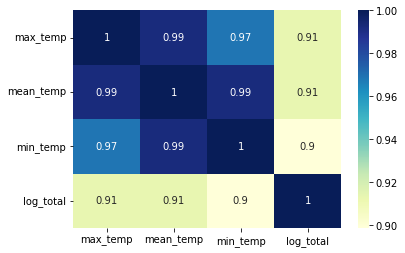

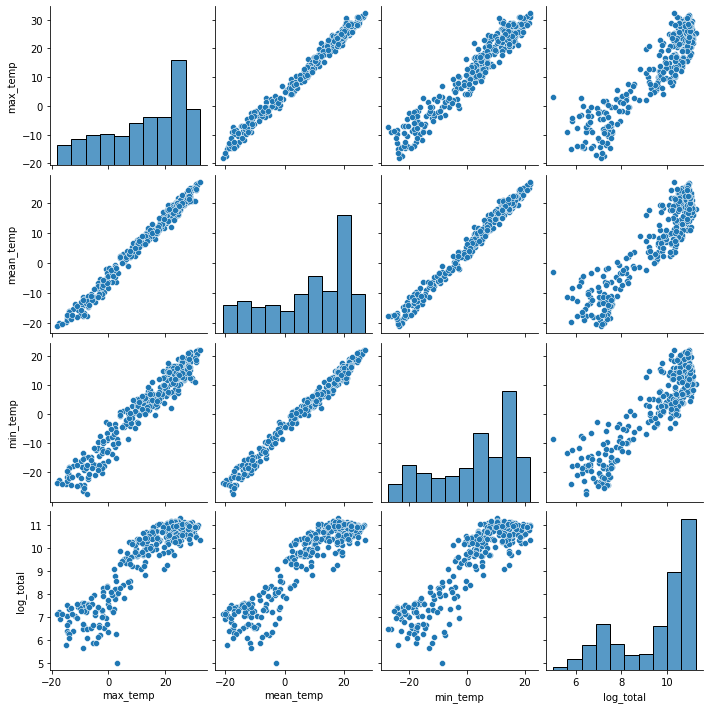

In [54]:
bike_and_weather['log_total']=np.log(bike_and_weather['total'])
sns.heatmap(bike_and_weather[['max_temp','mean_temp','min_temp','log_total']].corr(),annot=True, cmap="YlGnBu")
sns.pairplot(bike_and_weather[['max_temp','mean_temp','min_temp','log_total']])

It seems that the max and mean temp are a little more important than the min. This makes sense to me, because people usually bike during the day, when the temperature is closer to the max or the mean of the day. Because there is very little value added to keeping all three features, I only keep the maximum temperature.

In [55]:
bike_and_weather=bike_and_weather.drop(['mean_temp','min_temp'], axis=1);

*Note that now that we used the log_total for one feature, we need to keep using it for the following features.*

------

Now, we consider the other features. It is not because the correlation coefficient isn't high that a feature can't be a good predictor.
First, we consider the features related to precipitations.

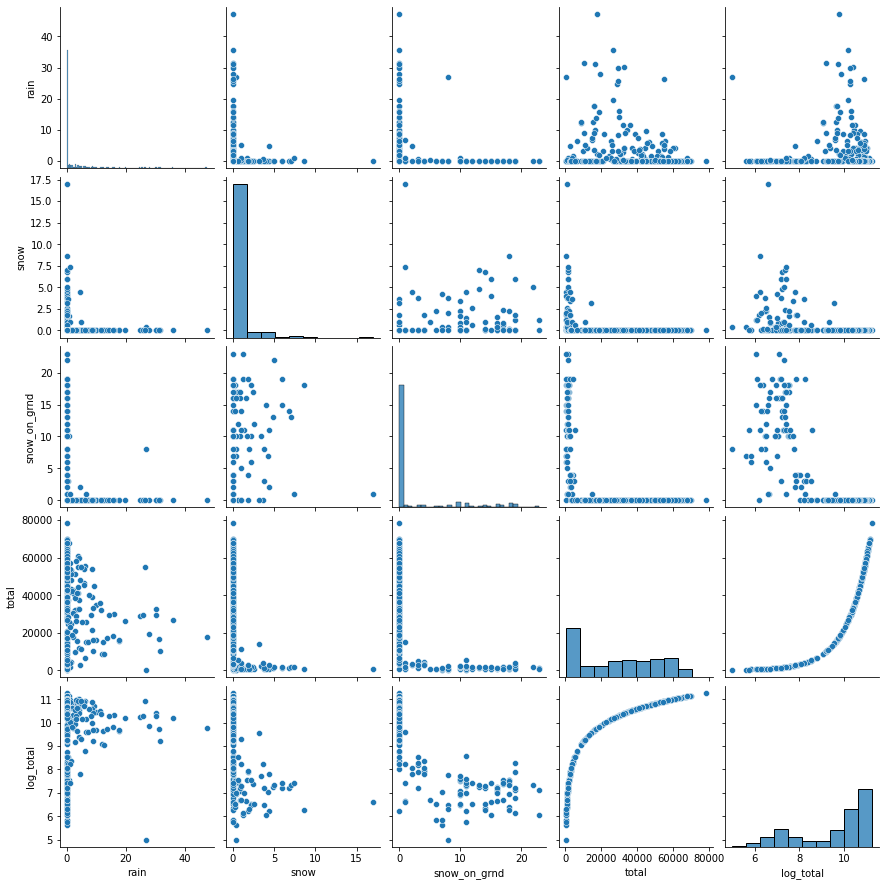

In [56]:
sns.pairplot(bike_and_weather[['rain','snow','snow_on_grnd','total','log_total']])

For those three variables, I observe, by looking a the pairplot with the total number of cyclists, that there is a cut off value (for snow and snow_on_grnd it is close to 0, for rain it is at about 15) for which it is almost impossible to have a lot of cyclists above (for the rain variable, being above 15 means the total will almost always be below 37500). Such a variable could be used in a decision tree. An idea of how to deal with these variables if we consider a regression, would be to find a good cutoff and transform these variables into binary. Alternatively, we can use transformations to increase the linear dependance (correlation).

This is what we do here, starting with the rain variable. It takes a little trial and error to find a good transformation to increase correlation.

correlation between rain and log_total 0.09237070537517156
correlation between log_rain and log_total 0.22120868398741356


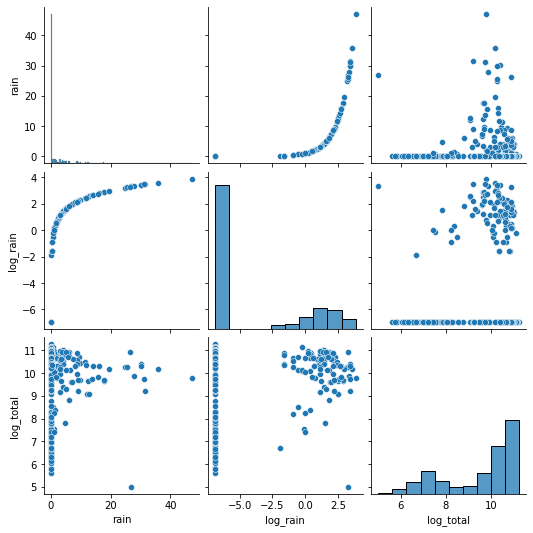

In [57]:
bike_and_weather['log_rain']=np.log(bike_and_weather['rain']+0.001) #I have added a very small value to the rain in order to take the log, because some values are 0.
sns.pairplot(bike_and_weather[['rain','log_rain','log_total']])
print('correlation between rain and log_total', bike_and_weather['rain'].corr(bike_and_weather['log_total']))
print('correlation between log_rain and log_total', bike_and_weather['log_rain'].corr(bike_and_weather['log_total']))
bike_and_weather=bike_and_weather.drop(['rain'], axis=1);

Now, we do the same for the snow variable.

correlation between snow and log_total -0.43495574553502353
correlation between snow_inv and log_total -0.6710023847676729


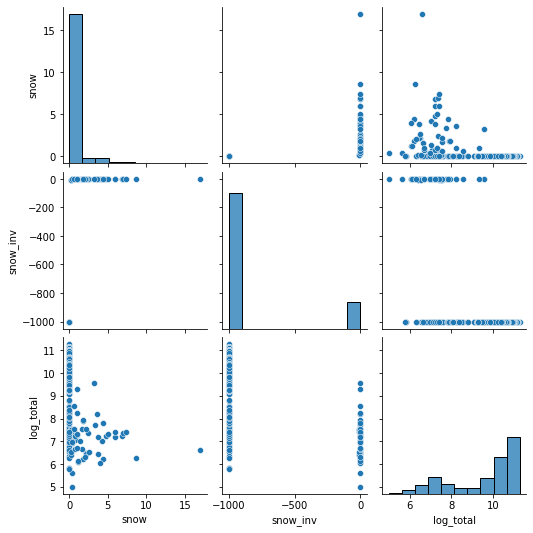

In [58]:
bike_and_weather['snow_inv']=-np.power(bike_and_weather['snow']+0.001,-1)
sns.pairplot(bike_and_weather[['snow','snow_inv','log_total']])
print('correlation between snow and log_total', bike_and_weather['snow'].corr(bike_and_weather['log_total']))
print('correlation between snow_inv and log_total', bike_and_weather['snow_inv'].corr(bike_and_weather['log_total']))
bike_and_weather=bike_and_weather.drop(['snow'], axis=1);

We can see that this transformation basically differentiates between the presence and absence of snow. Which, as I discussed earlier, is the most important factor.

Finally, we also transform the variable for the quantity of snow on the ground.

correlation between snow_on_grnd and log_total -0.8028574325910762
correlation between snow_on_grnd_inv and log_total -0.9012221286018095


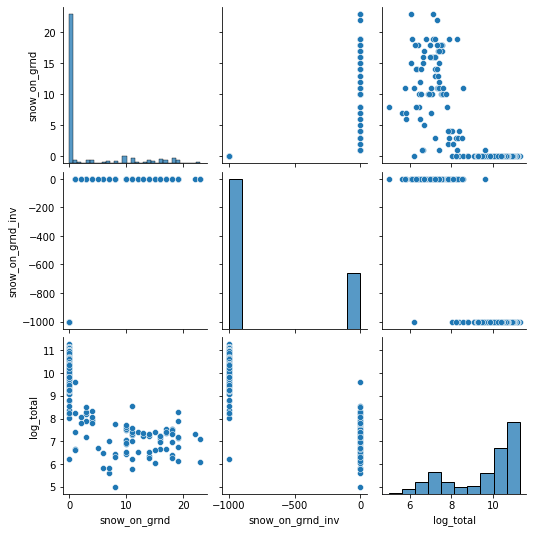

In [59]:
bike_and_weather['snow_on_grnd_inv']=-np.power(bike_and_weather['snow_on_grnd']+0.001,-1)
sns.pairplot(bike_and_weather[['snow_on_grnd','snow_on_grnd_inv','log_total']])
print('correlation between snow_on_grnd and log_total', bike_and_weather['snow_on_grnd'].corr(bike_and_weather['log_total']))
print('correlation between snow_on_grnd_inv and log_total', bike_and_weather['snow_on_grnd_inv'].corr(bike_and_weather['log_total']))
bike_and_weather=bike_and_weather.drop(['snow_on_grnd'], axis=1);

Once again, the new variable distinguishes between whether there is snow on the ground or not.

------
Finaly, we look at the weekend/holiday factor.

c:\Users\jorge.ruiz\Documents\Documentación\Quantization\Quantize-Inference\demo\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\jorge.ruiz\Documents\Documentación\Quantization\Quantize-Inference\demo\.venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


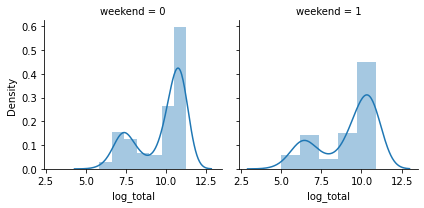

In [60]:
g=sns.FacetGrid(bike_and_weather, col='weekend')
g.map(sns.distplot, "log_total")

We can see that these distributions are similar (they are both bimodal), but there is less cyclists during the weekend and the holidays.

------
Finaly, I'll rescale all factors to be between 0 and 1. I could use the minmax_scaling function, but I want to be able to inverse this scaling in order to do analysis on the factors. Therefore, I keep track of the min and the max of each factor and scale them myself.

In [61]:
min_max = bike_and_weather.describe()
min_max

,total,max_temp,weekend,log_total,log_rain,snow_inv,snow_on_grnd_inv
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,28837.815047,12.989342,0.313480,9.522863,-4.252035,-834.052292,-727.318811
std,22431.867228,13.537389,0.464636,1.610449,3.925844,372.354356,445.986118
min,148.000000,-18.000000,0.000000,4.997212,-6.907755,-1000.000000,-1000.000000
25%,3163.500000,2.200000,0.000000,8.059360,-6.907755,-1000.000000,-1000.000000
50%,29859.000000,16.800000,0.000000,10.304242,-6.907755,-1000.000000,-1000.000000
75%,49242.000000,24.500000,1.000000,10.804502,0.337186,-1000.000000,-0.416486
max,78279.000000,32.200000,1.000000,11.268035,3.854415,-0.058820,-0.043476


In [62]:
scale_data = bike_and_weather.copy()
scale_data['max_temp']=(bike_and_weather['max_temp']-min_max.loc['min','max_temp'])/(min_max.loc['max','max_temp']-min_max.loc['min','max_temp'])
scale_data['log_rain']=(bike_and_weather['log_rain']-min_max.loc['min','log_rain'])/(min_max.loc['max','log_rain']-min_max.loc['min','log_rain'])
scale_data['snow_inv']=(bike_and_weather['snow_inv']-min_max.loc['min','snow_inv'])/(min_max.loc['max','snow_inv']-min_max.loc['min','snow_inv'])
scale_data['snow_on_grnd_inv']=(bike_and_weather['snow_on_grnd_inv']-min_max.loc['min','snow_on_grnd_inv'])/(min_max.loc['max','snow_on_grnd_inv']-min_max.loc['min','snow_on_grnd_inv'])

scale_data_rnd = scale_data.sample(frac=1)

# Keras Model

In [63]:
import tensorflow as tf
import tensorflow.keras as keras

In [71]:
scaler = MinMaxScaler()
min_max_data = scale_data.copy()

In [72]:
min_max_data[min_max_data.columns] = scaler.fit_transform(min_max_data[min_max_data.columns])

In [73]:
min_max_data.describe()

,total,max_temp,weekend,log_total,log_rain,snow_inv,snow_on_grnd_inv
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,0.367201,0.617318,0.313480,0.721700,0.246764,0.165957,0.272693
std,0.287106,0.269669,0.464636,0.256816,0.364782,0.372376,0.446006
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.038595,0.402390,0.000000,0.488317,0.000000,0.000000,0.000000
50%,0.380272,0.693227,0.000000,0.846305,0.000000,0.000000,0.000000
75%,0.628355,0.846614,1.000000,0.926081,0.673186,0.000000,0.999627
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [79]:
Y = min_max_data['total']
X = min_max_data.drop(["total", "log_total"], axis=1)

,max_temp,weekend,log_rain,snow_inv,snow_on_grnd_inv
Date,,,,,
2015-01-01,0.298805,1.0,0.000000,0.999504,0.000000
2015-01-02,0.290837,0.0,0.000000,0.000000,0.999044
2015-01-03,0.189243,1.0,0.000000,1.000000,0.999044
2015-01-04,0.418327,1.0,0.947411,0.997565,0.999918
2015-01-05,0.252988,0.0,0.000000,0.000000,0.999877


In [89]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.33, random_state=123)

with open("./data.npy", "wb") as f:
    numpy_data = {"train_x": train_x, "test_x": test_x, "train_y": train_y, "test_y": test_y, "X": X, "Y": Y}
    np.savez(f, **numpy_data)

print(train_x.shape)


(213, 5)


In [137]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(5,)),
    tf.keras.layers.Dense(2**3, activation="tanh"),
    tf.keras.layers.Dense(2**4, activation="tanh"),
    
    #tf.keras.layers.Dense(2**5, activation="tanh"),
    tf.keras.layers.Dense(2**6, activation="tanh"),
    #tf.keras.layers.Dense(2**8, activation="tanh"),

    #tf.keras.layers.Dense(2**5, activation="tanh"),
    tf.keras.layers.Dense(2**4, activation="tanh"),
    tf.keras.layers.Dense(2**3, activation="tanh"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
    
    ])

model.compile(loss="mse", optimizer="adam" )
history = model.fit(train_x, train_y, epochs=100,  validation_data=(test_x, test_y),)



Epoch 1/100
7/7 [==============================] - 1s 38ms/step - loss: 0.0938 - val_loss: 0.0593
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0500 - val_loss: 0.0479
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0448 - val_loss: 0.0403
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0352 - val_loss: 0.0325
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0298 - val_loss: 0.0292
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0258 - val_loss: 0.0253
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0220 - val_loss: 0.0227
Epoch 8/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0187 - val_loss: 0.0202
Epoch 9/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0165 - val_loss: 0.0187
Epoch 10/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0150 - val_loss: 0.0179
Epoch 11/100
7/7 [=======

In [151]:
predicted_y = model.predict(X)
predicted_y.shape
model.save("model.h5")

10/10 [==============================] - 0s 1ms/step


In [153]:
import plotly.express as px
linespace = np.linspace(1, 365, len(Y))
print(linespace.shape)

px.line(x=linespace, y=[Y, predicted_y.squeeze()], labels={'x':'Day', 'y':["a", "b"]})


(319,)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=wide_variable_0<br>Day=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'wide_variable_0',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'wide_variable_0',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([  1.        ,   2.14465409,   3.28930818, ..., 362.71069182,
                          363.85534591, 365.        ]),
              'xaxis': 'x',
              'y': array([0.00447966, 0.00801218, 0.00762821, ..., 0.23524593, 0.13316097,
                          0.13431288]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=wide_variable_1<br>Day=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'wide_variable_1',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'wide_variable_1',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([  1.        ,   2.14465409,   3.28930818, ..., 362.71069182,
                          363.85534591, 365.        ]),
              'xaxis': 'x',
              'y': array([0.04196015, 0.02605134, 0.01854169, ..., 0.23864503, 0.1440782 ,
                          0.18847615]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Day'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'value'}}}
})

In [108]:
print(predicted_y)

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.  


------
3- Modeling
===
As I have a very small data set, I'll use cross validation to evaluate the quality of my model.


First, I'll set the data.

In [78]:
y= scale_data_rnd['total']
y_log = scale_data_rnd['log_total']
X = scale_data_rnd.drop(['total','log_total'], axis=1)

--------
 I'll use XGBoost. XGBoost uses several decision trees and combines them to create predictions. As it uses decision trees, this model doesn't requires linearity (I still transformed my variables to increase linearity as an exercice).


In [46]:
# Add silent=True to avoid printing out updates with each cycle
model = XGBRegressor(silent=True)
scores = cross_val_score(model, X, y_log, scoring='neg_mean_absolute_error')
model.fit(X, y_log)
print(scores/(min_max.loc['max','log_total']-min_max.loc['min','log_total']))

As the mean absolute error is pretty low and constant, I think this is a pretty good model.

I plot the importance of different variables. This is a count of how many times each feature is used for a split in the many decision trees created by XGB.

In [47]:
xgb.plot_importance(model)

Now, we plot the results

In [48]:
y_pred = model.predict(X)
scale_data_rnd['pred']=np.exp(y_pred)
scale_data_rnd[['total','pred']].plot(figsize=(20,8))

This is a really good fit! So good that one might actually be concerned about overfitting. But as I used cross validation, I believe that the number of cyclist is just really correlated with the weather and whether it's a work day or not! Also, given that I used so few predictors, it is less possible to have overfitting. 

------
Finally, to use the model, I need to transform the original data. I created this function which takes in the maximum temperature, the quantity of rain, snow and snow on the ground and whether it's a work day or not, and outputs the predicted number of cyclists on the Montréal bike lanes for a day.

**Note that as the model was created with 2015 values using only some bike lanes, it can only be used to estimate number of cyclists for those bike lanes in Montréal during that year. I believe this work could be extended to other cities or other years.**

In [49]:
def predict_cyclist(model , max_temp, weekend, rain,snow, snow_on_grnd):
    temp = pd.DataFrame(columns=['max_temp','weekend','log_rain','snow_inv','snow_on_grnd_inv'])
    max_temp_model = (max_temp-min_max.loc['min','max_temp'])/(min_max.loc['max','max_temp']-min_max.loc['min','max_temp'])
    log_rain = (np.log(rain+0.001)-min_max.loc['min','log_rain'])/(min_max.loc['max','log_rain']-min_max.loc['min','log_rain'])
    snow_inv = (-np.power(snow+0.001,-1))/(min_max.loc['max','snow_inv']-min_max.loc['min','snow_inv'])
    snow_on_grnd_inv = (-np.power(snow_on_grnd+0.001,-1)-min_max.loc['min','snow_on_grnd_inv'])/(min_max.loc['max','snow_on_grnd_inv']-min_max.loc['min','snow_on_grnd_inv'])
    temp.loc[0] = [max_temp_model,weekend,log_rain,snow_inv,snow_on_grnd_inv]
    return np.exp(model.predict(temp))

In [50]:
predict_cyclist(model,20,0,0,0,0)